# A2a Signal Detection
Ryan Lin

In [10]:
from A2a_rhl72 import *
import matplotlib.pyplot as plt


## Wave Forms
---

$$
y[t] = x[t] + \epsilon[t]
$$

- y is the wave 
- x is the events 
- epsilon is the noise


## 1A 1B

In [11]:
def genwaveform(N=100, alpha=0.1, A=1, mu=0, sigma=1, noisetype='Gaussian'):
    """
    Generates a waveform with:
    - N: length of time.
    - alpha: probability of an event at each sample.
    - A: magnitude of event (always positive).
    - mu: center of the noise distribution.
    - sigma: noise standard deviation.
    - noisetype: 'Gaussian' or 'Uniform'.
    """
    # Generate signal locations (1 indicates an event, 0 no event)
    events = (np.random.rand(N) < alpha).astype(int)
    
    # Multiply by A (always positive, since we use np.random.choice([1], ...))
    events *= A * np.random.choice([1], size=N)
    
    # Generate noise
    if noisetype == 'Gaussian':
        noise = np.random.normal(mu, sigma, N)
    elif noisetype == 'Uniform':
        noise = np.random.uniform(mu - sigma/2, mu + sigma/2, N)
    else:
        raise ValueError(f"Unsupported Noise Type: {noisetype}")
    
    # Create the waveform by adding the events and noise
    wave = noise + events

    return wave, np.where(events != 0)[0]

In [12]:
def plot_waveform(N=100, alpha=0.1, A=1, mu=0, sigma=1, noisetype='Gaussian', threshold=None):
    """
    Generates and plots the waveform with event markers.
    If a threshold is provided, a dotted horizontal line is drawn at that level.
    """
    # Generate waveform and event indices
    wave, event_indices = genwaveform(N, alpha, A, mu, sigma, noisetype)
    
    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(wave, label=f'Waveform (Noise: {noisetype})', color='b')
    plt.scatter(event_indices, wave[event_indices], color='red', label="Events", marker='o')
    
    # Add a single threshold line if specified (only positive threshold needed)
    if threshold is not None:
        plt.axhline(threshold, color='green', linestyle="dotted")
    
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title(f"Generated Waveform with Magnitude {A}")
    plt.legend()
    plt.grid()
    plt.show()

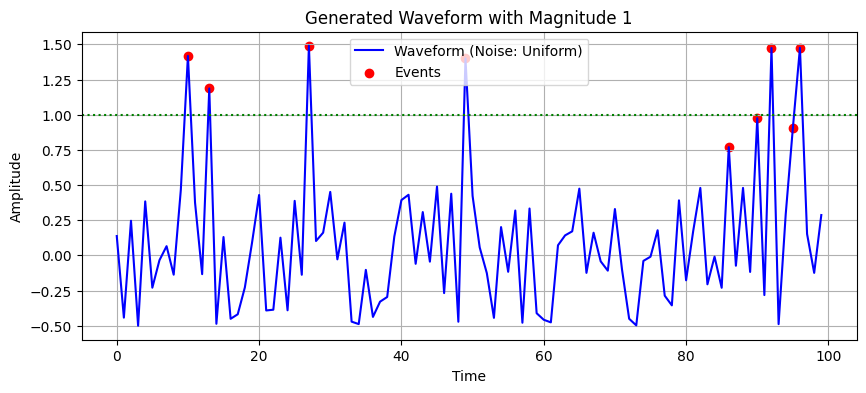

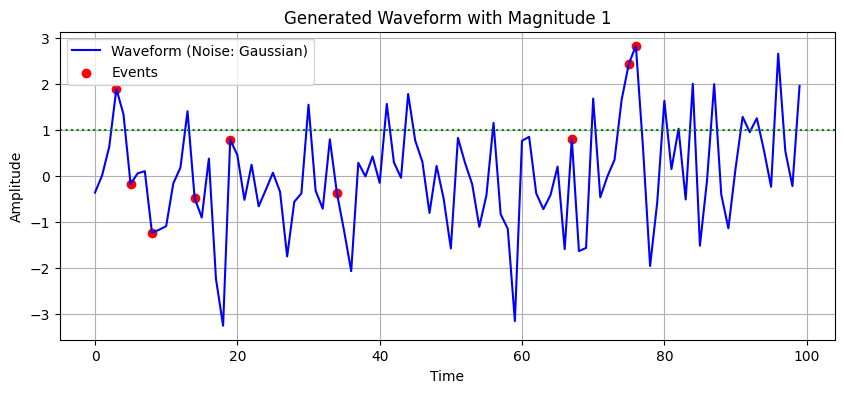

In [60]:
plot_waveform(N=100, alpha=0.1, A=1, mu=0, sigma=1, noisetype='Uniform', threshold=1)
plot_waveform(N=100, alpha=0.1, A=1, mu=0, sigma=1, noisetype='Gaussian', threshold=1)

SNR High vs Low

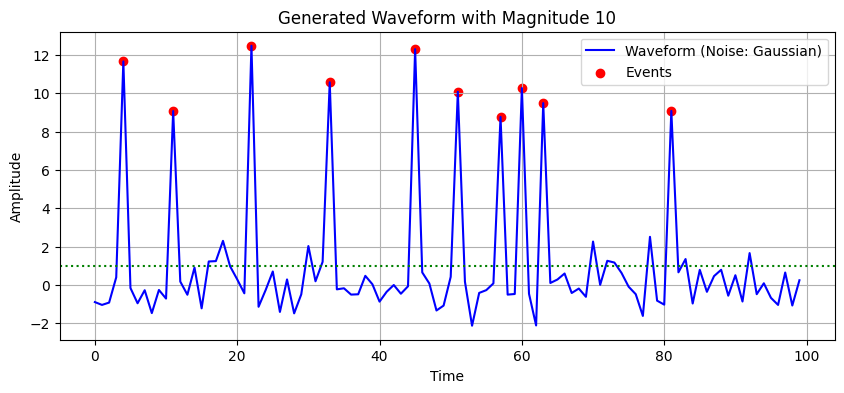

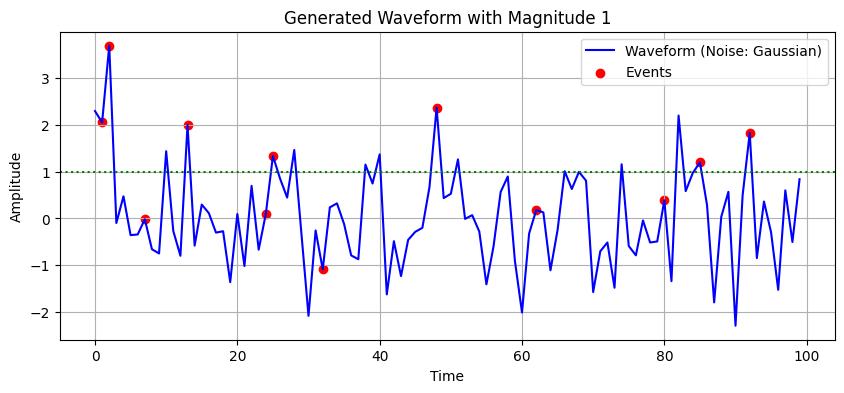

In [61]:

plot_waveform(N=100, alpha=0.1, A=10, mu=0, sigma=1, noisetype='Gaussian', threshold=1)
plot_waveform(N=100, alpha=0.1, A=1, mu=0, sigma=1, noisetype='Gaussian', threshold=1)

## 1C

## Impulse Representation

Each event x is modeled as an impulse with a fixed amplitude **A**.

In discrete terms it could be represented as

$$
\delta [t - \tau]
$$

The full signal can be computed as 
$$
x[t] = \sum_{i=1}^{N} A * \delta [t - \tau_i]
$$

*brackets indicate discrete*

## Types of Noise

### **Gaussian Noise**
Event $\epsilon[t]$ is sampled from a normal distribution

$$
\epsilon[t] \sim \mathcal{N}(0,\sigma^2)
$$

### **Uniform Noise**
Event $\epsilon[t]$ is drawn from a uniform distribution with zero mean and a range defined by $\sigma$

$$
[-\frac{\sigma}{2}, \frac{\sigma}{2}]
$$

# 2a

## Detection Under Uncertainty
The observed waveform $y[t]$ is a mixture of signal $x[t]$ and noise $\epsilon[t]$. To detect whether an event occurred at a specific time $t$, a threshold $\theta$ is set:

- If $y[t] \geq \theta$, an event is detected.
- Otherwise, no event is detected.

## Impact of Parameters and Noise Type

### Event Amplitude ($A$) and Noise Level ($\sigma$)
- A larger $A$ or a smaller $\sigma$ (ex. a higher signal-to-noise ratio) improves detection.

### Event Probability ($\alpha$)
- Determines event sparsity. Very low $\alpha$ may lead to too few events, complicating statistical estimation.

### Noise Distribution
- **Gaussian Noise:** Tails decay exponentially, affecting false alarm probabilities.
- **Uniform Noise:** Has finite support, limiting extreme noise values.

## Extreme Cases

### Pure Chance Detection
- When noise dominates ($\sigma$ is much larger than $A$), detection becomes almost random.

### Certain Detection
- When $A$ is significantly larger than $\sigma$, the signal clearly exceeds noise, making detection nearly perfect.


# 2b

In [70]:
# Generate waveform
N = 200
alpha = 0.05
A = 2
mu = 0
sigma = 1
threshold = 1.5

# Get waveform and event indices
wave, true_events = genwaveform(N, alpha, A, mu, sigma, 'Gaussian')

# Get detection counts
results = detectioncounts(true_events, wave, threshold)
print(results)


DetectionCounts(TP=3, FN=2, FP=19, TN=176)


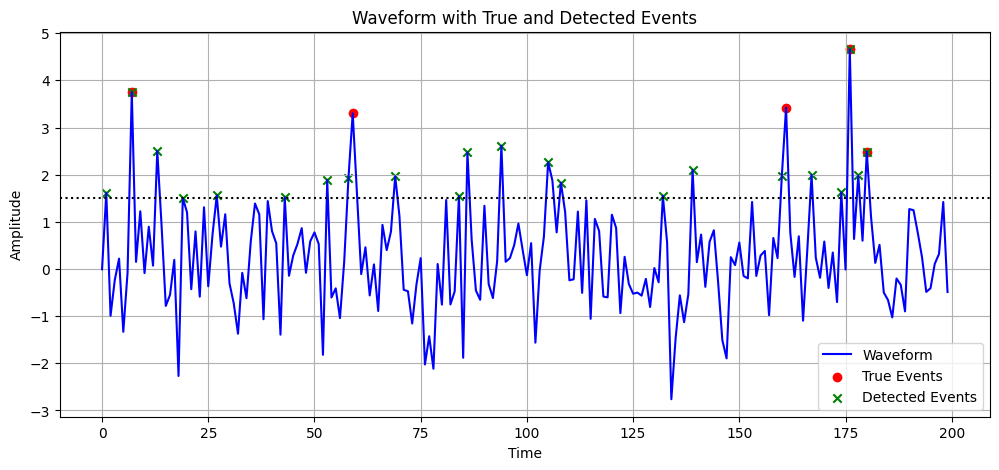

In [71]:
plot_detection_results(N, wave, true_events, threshold)

# 2c

In [16]:
# Define parameters
θ = 1.5  # Detection threshold
A = 2  # Event amplitude
mu = 0  # Noise mean
sigma = 1  # Noise standard deviation

# Compute probabilities
fp_gaussian = falsepos(θ, mu, sigma, 'Gaussian')
fn_gaussian = falseneg(θ, A, mu, sigma, 'Gaussian')

fp_uniform = falsepos(θ, mu, sigma, 'Uniform')
fn_uniform = falseneg(θ, A, mu, sigma, 'Uniform')

# Print results
print(f"False Positive Probability (Gaussian): {fp_gaussian:.4f}")
print(f"False Negative Probability (Gaussian): {fn_gaussian:.4f}")

print(f"False Positive Probability (Uniform): {fp_uniform:.4f}")
print(f"False Negative Probability (Uniform): {fn_uniform:.4f}")


False Positive Probability (Gaussian): 0.0668
False Negative Probability (Gaussian): 0.3085
False Positive Probability (Uniform): 0.0000
False Negative Probability (Uniform): 0.0000


In [51]:
# Generate waveform
N = 1000
alpha = 0.1
wave, true_events = genwaveform(N, alpha, A, mu, sigma, 'Gaussian')

# Get empirical detection counts
results = detectioncounts(true_events, wave, θ)

# Compute empirical rates
empirical_fp_rate = results.FP / (results.FP + results.TN)
empirical_fn_rate = results.FN / (results.FN + results.TP)

print(f"Empirical False Positive Rate: {empirical_fp_rate:.4f}")
print(f"Empirical False Negative Rate: {empirical_fn_rate:.4f}")

print(f"Analytical False Positive Rate: {fp_gaussian:.4f}")
print(f"Analytical False Negative Rate: {fn_gaussian:.4f}")


Empirical False Positive Rate: 0.0676
Empirical False Negative Rate: 0.4021
Analytical False Positive Rate: 0.0668
Analytical False Negative Rate: 0.3085


In [81]:
import scipy.stats as stats
import numpy as np

def total_error(theta, alpha=0.25, A=2, mu=0, sigma=1, noisetype='Gaussian'):
    """
    Computes the total error probability (false positives + false negatives).
    """
    if noisetype == 'Gaussian':
        P_FP = falsepos(theta, mu, sigma, noisetype)
        P_FN = stats.norm.cdf(theta, loc=A + mu, scale=sigma)
        return alpha * P_FN + (1 - alpha) * P_FP
    else:
        raise ValueError("Unsupported noise type. Choose 'Gaussian'.")

# Compute the probability of a false positive
theta = 2
mu = 0
sigma = 1
noisetype = 'Gaussian'
P_FP = falsepos(theta, mu, sigma, noisetype)

print(f"Analytic probability of false positive: {P_FP:.4f}")


# Find the threshold that minimizes total errors
from scipy.optimize import minimize_scalar

alpha = 0.25
A = 2

result = minimize_scalar(total_error, bounds=(0, A + 3*sigma), method='bounded', args=(alpha, A, mu, sigma, noisetype))

optimal_theta = result.x
print(f"Threshold that minimizes total errors: {optimal_theta:.4f}")


Analytic probability of false positive: 0.0228
Threshold that minimizes total errors: 1.5493


# 2c

## Understanding False Positive and False Negative Rates

In signal detection, we classify detections based on whether an event was **correctly** or **incorrectly** identified. Two key types of errors are:

- **False Positive (FP):** A noise fluctuation **crosses the threshold**, falsely detected as a signal.
- **False Negative (FN):** A real event occurs, but its magnitude is **below the threshold**, causing a missed detection.

To quantify these errors, we derive their probabilities using the underlying **noise distribution**.

---

## Mathematical Formulation

### False Positive Probability: $P(\text{FP})$

A **false positive** occurs when the noise alone causes a detection:

$$
P(\text{FP}) = P(y[t] \geq \theta \mid \text{signal absent})
$$

Since the observed signal is purely noise $ \epsilon[t] $, we get:

$$
P(\text{FP}) = P(\epsilon[t] \geq \theta)
$$

- **For Gaussian noise** $ \epsilon[t] \sim \mathcal{N}(\mu, \sigma^2) $:

$$
P(\text{FP}) = 1 - \Phi\left(\frac{\theta - \mu}{\sigma}\right)
$$

where $ \Phi(x) $ is the **Cumulative Distribution Function (CDF)** of the standard normal distribution.

- **For Uniform noise** $ \epsilon[t] \sim U(\mu - \sigma/2, \mu + \sigma/2) $:

$$
P(\text{FP}) = \frac{\mu + \sigma/2 - \theta}{\sigma}, \quad \text{if } \theta < \mu + \sigma/2
$$

otherwise, $ P(\text{FP}) = 0 $ because uniform noise has bounded support.

---

### False Negative Probability: $P(\text{FN})$

A **false negative** occurs when a real event **fails to exceed** the threshold:

$$
P(\text{FN}) = P(y[t] < \theta \mid \text{signal present})
$$

Since the observed signal consists of an event $ A $ plus noise $ \epsilon[t] $:

$$
P(\text{FN}) = P(A + \epsilon[t] < \theta)
$$

- **For Gaussian noise**:

$$
P(\text{FN}) = \Phi\left(\frac{\theta - (A + \mu)}{\sigma}\right)
$$

- **For Uniform noise**:

$$
P(\text{FN}) = \frac{\theta - (\mu + A) + \sigma/2}{\sigma}, \quad \text{if } \theta > \mu + A - \sigma/2
$$

otherwise, $ P(\text{FN}) = 0 $.

---



# 3a

In detection problems, there is generally no "one-size-fits-all" optimal threshold because of the inherent trade-off between false positives and false negatives.

- **Lowering the Threshold:**  
  A lower threshold increases the likelihood of detecting true events (reducing false negatives). However, it also increases the chance that noise alone will exceed the threshold, leading to more false positives.

- **Raising the Threshold:**  
  A higher threshold reduces false positives (since noise is less likely to trigger a detection) but may miss some true events, thereby increasing false negatives.

---

### Minimizing Total Error Probability

The threshold that minimizes the **expected total error probability** balances the rates of false positives and false negatives. If we denote:
- The probability of a false positive as $P(\text{FP})$,
- The probability of a false negative as $P(\text{FN})$,

then the total error probability is given by:

$$
P(\text{error}) = P(\text{FP}) + P(\text{FN})
$$

Under the assumption of equal costs for both types of errors, the **Bayes optimal threshold** is the value of $\theta$ that minimizes this expected error.

---

### Minimizing the Total Number of Errors

It is important to distinguish between minimizing the expected error probability and minimizing the observed number of errors on a given dataset:

- **Expected Error Probability:**  
  This is an average measure computed over many trials based on the statistical distributions of the noise and the signal. The Bayes optimal threshold minimizes this expectation.

- **Observed Error Count:**  
  In any finite dataset, the actual counts of false positives and false negatives may vary due to sampling variability. For instance, if events are rare, even the Bayes optimal threshold might result in a high number of false positives simply because there are many more non-event samples.

Thus, the threshold that minimizes the expected error probability might not always coincide with the threshold that minimizes the actual number of errors in a specific dataset.

---

**Summary:**  
The **Bayes optimal threshold** minimizes the expected total error probability by balancing false positives and false negatives. However, due to sampling variability and class imbalances, this threshold may not minimize the observed total error count in any particular finite dataset.


# 3b

In [52]:
def plotROC(N=100, alpha=0.1, A=1, mu=0, sigma=1, noisetype='Gaussian', thresholds=None):
    """
    Generates a waveform and plots the ROC curve by varying the threshold.
    
    Parameters:
    - N: Length of the waveform.
    - alpha: Event probability at each sample.
    - A: Magnitude of the event.
    - mu: Mean of the noise distribution.
    - sigma: Standard deviation (or spread) of the noise.
    - noisetype: 'Gaussian' or 'Uniform'.
    - thresholds: Array of threshold values to evaluate. If None, thresholds are generated automatically.
    """
    # Generate waveform and get true event indices
    wave, true_events = genwaveform(N, alpha, A, mu, sigma, noisetype)
    
    # Define a range of thresholds if not provided.
    if thresholds is None:
        # Use a range that covers the observed values
        t_min = np.min(wave)
        t_max = np.max(wave)
        thresholds = np.linspace(t_min, t_max, 100)
    
    TPR_list = []
    FPR_list = []
    
    # Loop over thresholds to compute detection performance
    for theta in thresholds:
        counts = detectioncounts(true_events, wave, theta)
        TP, FN, FP, TN = counts.TP, counts.FN, counts.FP, counts.TN
        
        # Calculate True Positive Rate (Sensitivity) and False Positive Rate
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
        
        TPR_list.append(TPR)
        FPR_list.append(FPR)
    
    # Plot the ROC curve
    plt.figure(figsize=(6, 6))
    plt.plot(FPR_list, TPR_list, marker='o', linestyle='-', label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


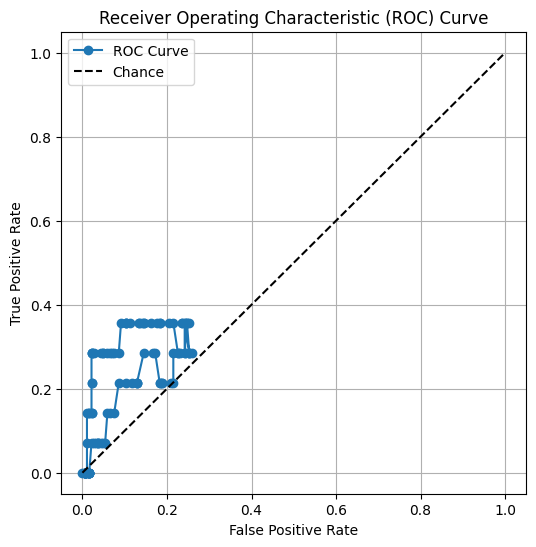

In [53]:
plotROC(N=200, alpha=0.05, A=1, mu=0, sigma=1, noisetype='Gaussian')
